In [1]:
import os
import SimpleITK as sitk
import glob
import monai
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    AddChanneld,
    SpatialPadd,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    EnsureType,
    MapTransform,
    Resized,
    Invertd,
    ToTensord,
    NormalizeIntensityd,
    RandFlipd,
    Lambdad,
    Activations,
    AsDiscrete,
)
from monai.metrics import ROCAUCMetric
from monai.data import CacheDataset, ThreadDataLoader,DataLoader, Dataset, decollate_batch,load_decathlon_datalist
import torch
from monai.utils import first, set_determinism
import torch.nn as  nn
from torch.nn import Linear,  Softmax
import torch.nn.functional as F
import pandas as pd
from sklearn import metrics
torch.multiprocessing.set_sharing_strategy('file_system')

In [46]:
# model_path = '/app/liucd/deeplearn_dec/DL_multi/NewTrain2Val3/net_selfattnNew/hidden/Loss/FocalLoss/model_0.796_0.853.pth'
# model_path = '/app/liucd/deeplearn_dec/DL_multi/NewTrain2Val3/net_selfattnNew/hidden/LR/HighLR/best_metric_model_classification3d_dict.pth'
model_path = '../LR1e-3/model_24_0.8026_0.8700.pth'

In [3]:
df_raw = pd.read_csv('/app/liucd/判定_fill_df.csv')
df_cli = df_raw[['patient_ID', 'T_stage', 'HER2_status', 'NAC_classification', 'ER_percentage', 'PR_percentage', 'Ki_67']]


In [4]:
syf_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/syf/Mixed'
zy_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/zunyi/Mixed'

sd_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/shandong/Mixed'
yizhong_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/yizhong/Mixed'
xian_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed'


syf_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/syf/Mixed'
zy_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/zunyi/Mixed'

sd_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/shandong/Mixed'
yizhong_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/yizhong/Mixed'
xian_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed'


train_adcimages = sorted(glob.glob(os.path.join(syf_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(zy_adcdir,  '*.nii.gz')))


train_dceimages = sorted(glob.glob(os.path.join(syf_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(zy_dcedir,  '*.nii.gz')))



val_adcimages =  sorted(glob.glob(os.path.join(sd_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_adcdir,  '*.nii.gz'))) 

val_dceimages =  sorted(glob.glob(os.path.join(sd_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_dcedir,  '*.nii.gz'))) 


val_clinical = []
for file_path in val_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    val_clinical.append(clinical_data)

val_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, clinical in zip(val_adcimages, val_dceimages, val_clinical)]



train_clinical = []
for file_path in train_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    train_clinical.append(clinical_data)

train_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, clinical in zip(train_adcimages,  train_dceimages, train_clinical)]

print(val_dict[-1])
print(len(val_dict))
print(train_dict[-1])
print(len(train_dict))

{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed/236_1412879_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed/236_1412879_+C2_0000_0.nii.gz', 'clinical': [1.0, 0.0, 2.0, 0.0, 0.0, 0.7], 'label': 0}
618
{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/zunyi/Mixed/2022_10_20_1650366_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/zunyi/Mixed/2022_10_20_1650366_+C2_0000_0.nii.gz', 'clinical': [3.0, 1.0, 2.0, 0.0, 0.0, 0.2], 'label': 0}
691


In [5]:

sd_adcimages =  sorted(glob.glob(os.path.join(sd_adcdir,  '*.nii.gz'))) 
yizhong_adcimages = sorted(glob.glob(os.path.join(yizhong_adcdir,  '*.nii.gz'))) 
xian_adcimages = sorted(glob.glob(os.path.join(xian_adcdir,  '*.nii.gz'))) 

sd_dceimages =  sorted(glob.glob(os.path.join(sd_dcedir,  '*.nii.gz'))) 
yizhong_dceimages =  sorted(glob.glob(os.path.join(yizhong_dcedir,  '*.nii.gz')))
xian_dceimages =  sorted(glob.glob(os.path.join(xian_dcedir,  '*.nii.gz'))) 


sd_clinical = []
yizhong_clinical = []
xian_clinical = []
for file_path in sd_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    sd_clinical.append(clinical_data)

for file_path in yizhong_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    yizhong_clinical.append(clinical_data)

for file_path in xian_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    xian_clinical.append(clinical_data)

sd_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, clinical in zip(sd_adcimages, sd_dceimages, sd_clinical)]

yizhong_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, clinical in zip(yizhong_adcimages, yizhong_dceimages, yizhong_clinical)]

xian_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, clinical in zip(xian_adcimages, xian_dceimages, xian_clinical)]

print(sd_dict[-1])
print(yizhong_dict[-1])
print(xian_dict[-1])
len(sd_dict), len(yizhong_dict), len(xian_dict)

{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/shandong/Mixed/516_xu_feng_hua_637730_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/shandong/Mixed/516_xu_feng_hua_637730_+C2_0000_0.nii.gz', 'clinical': [3.0, 1.0, 2.0, 0.9, 0.9, 0.3], 'label': 0}
{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/yizhong/Mixed/205_1510029_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/yizhong/Mixed/205_1510029_+C2_0000_0.nii.gz', 'clinical': [2.0, 0.0, 2.0, 0.8, 0.2, 0.5], 'label': 0}
{'image_adc': '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed/236_1412879_ADC2_0000_0.nii.gz', 'image_dce': '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed/236_1412879_+C2_0000_0.nii.gz', 'clinical': [1.0, 0.0, 2.0, 0.0, 0.0, 0.7], 'label': 0}


(236, 200, 182)

In [13]:
val_transforms = Compose(
        [
            LoadImaged(keys=["image_adc",'image_dce' ]),
            EnsureChannelFirstd(keys=["image_adc", 'image_dce']),
            Orientationd(keys=["image_adc",'image_dce'], axcodes="RAS"),
            Resized(keys=["image_adc"], spatial_size=(64, 64, 16)),
            Resized(keys=["image_dce"], spatial_size=(96, 96, 32)),
            
            NormalizeIntensityd(keys=["image_adc", 'image_dce'], nonzero=True, channel_wise=True),
            ToTensord(keys=['image_adc', 'image_dce','clinical', 'label'])
        ]
    )


val_ds = Dataset(data=val_dict, transform=val_transforms)
train_ds = Dataset(data=train_dict, transform=val_transforms)
sd_ds = Dataset(data=sd_dict, transform=val_transforms)
yizhong_ds = Dataset(data=yizhong_dict, transform=val_transforms)
xian_ds = Dataset(data=xian_dict, transform=val_transforms)

# create a validation data loader
val_loader = DataLoader(val_ds, batch_size=12, num_workers=16, pin_memory=True)
train_loader = DataLoader(train_ds, batch_size=12, num_workers=16, pin_memory=True)
sd_loader = DataLoader(sd_ds, batch_size=1, num_workers=16, pin_memory=True)
yizhong_loader = DataLoader(yizhong_ds, batch_size=1, num_workers=16, pin_memory=True)
xian_loader = DataLoader(xian_ds, batch_size=1, num_workers=16, pin_memory=True)

In [8]:

class DoubleTower(nn.Module):
    def __init__(self,
                 pretrained_dce='',
                 pretrained_adc='',
                 device = torch.device("cuda"),
                 num_classes=2,
                 fc_hidden_size = 256
                ):
        super().__init__()
        self.pretrained_dce = pretrained_dce
        self.pretrained_adc = pretrained_adc
        self.fc_hidden_size = fc_hidden_size
        self.num_classes = num_classes
        self.device = device

        self.model_dce = monai.networks.nets.resnet18(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)
        self.model_adc = monai.networks.nets.resnet18(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)

        if  pretrained_dce != '':
            dce_dict = self.model_dce.state_dict()
            dce_pretrain = torch.load(self.pretrained_dce, map_location=self.device)
            dce_pretrain_dict = {k:v for k, v in dce_pretrain.items() if  k in  dce_dict.keys()}
            dce_dict.update(dce_pretrain_dict)
            self.model_dce.load_state_dict(dce_dict)

        if  pretrained_adc !='':
            adc_dict = self.model_adc.state_dict()
            adc_pretrain = torch.load(self.pretrained_adc, map_location=self.device)
            adc_pretrain_dict = {k:v for k, v in adc_pretrain.items() if  k in  adc_dict.keys()}
            adc_dict.update(adc_pretrain_dict)
            self.model_adc.load_state_dict(adc_dict)

        self.attn = nn.MultiheadAttention(512, num_heads=8, batch_first=True, device=self.device)

        # self.Linear1 = Linear(1024 + 6, self.num_classes, device=self.device)
        self.Linear1 = Linear(512, self.fc_hidden_size, device=self.device)  # 1024 是 所有下采样特征图globalpool之后拼接的结果
        self.Linear2 = Linear(self.fc_hidden_size + 6, self.num_classes, device=self.device)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x1, x2, structured_data):  # x 是SegResNet的输入影像矩阵

        encode_output1 = self.model_dce(x1)
        encode_output2 = self.model_dce(x2)

        concatenated = encode_output1 * encode_output2
        
        concatenated = concatenated.unsqueeze(1)
        attn_output, _ = self.attn(concatenated, concatenated, concatenated)

        attn_output = attn_output.squeeze(1)

        fc1 = F.relu(self.Linear1(attn_output))
        fc1 = self.dropout(fc1)

        fc2 = self.Linear2( torch.concat([fc1, structured_data], dim=-1))
   
        return F.log_softmax(fc2, dim=-1)


In [50]:

# dce_pretrain_path = ''
# adc_pretrain_path = ''

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = DoubleTower(device = device)
model_path =  '../LR1e-3again/model_47_0.8042_0.8528.pth'
pretrained_path = os.path.join(model_path)
model.load_state_dict(torch.load(pretrained_path, map_location=device))


<All keys matched successfully>

In [51]:
def report_metric(label_list, pred_list):
    Cmatrix = metrics.confusion_matrix(label_list, pred_list)
    TN = Cmatrix[0, 0]
    TP = Cmatrix[1, 1]
    FN = Cmatrix[1, 0]
    FP = Cmatrix[0, 1]

    Acc = (TP+TN) / (TP+TN+FP+FN)
    sensitivity = TPR = Recall = TP / (TP+FN)
    specificity = TNR =  TN / (FP+TN)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    
    return Acc, sensitivity, specificity, PPV, NPV

In [52]:
post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])

auc_metric = ROCAUCMetric()

prob_list = []
label_list = []

model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in train_loader:

        val_dce, val_adc, val_clinical, val_labels = val_data["image_dce"].to(device),val_data["image_adc"].to(device), val_data["clinical"].to(device), val_data["label"].to(device)
        val_output = model(val_dce, val_adc, val_clinical)
         
#         prob_list.append(post_pred(val_output[0])[1].item())  # [0] 是由于设置batch=1 [1] 是是取预测类别中的1类别
#         label_list.append(val_labels.item())
        
        # monai
        y_pred = torch.cat([y_pred, val_output], dim=0)
        y = torch.cat([y, val_labels], dim=0)
        
        y_onehot = [post_label(i) for i in decollate_batch(y, detach=False)]
        y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]

# # sklearn
# pred_list = [round(i) for i in prob_list]
# Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
# print('Accuray:', Acc)
# print('SEN/SPE:', sensitivity, specificity)
# print('PPV/NPV: ', PPV, NPV)

# fpr, tpr, thresholds = metrics.roc_curve(label_list, prob_list, pos_label=1)
# print(metrics.auc(fpr, tpr))

# # monai
auc_metric(y_pred_act, y_onehot)
print(auc_metric.aggregate())

acc_value = torch.eq(y_pred.argmax(dim=1), y)
acc_metric = acc_value.sum().item() / len(acc_value)
print(acc_metric)

0.8752139741206354
0.7930535455861071


In [ ]:
0.8611033221578787
0.7702265372168284

0.47
0.7932148626817448 0.4845360824742268 0.9341176470588235 0.7704918032786885 0.7987927565392354


Text(0, 0.5, 'Accuracy')

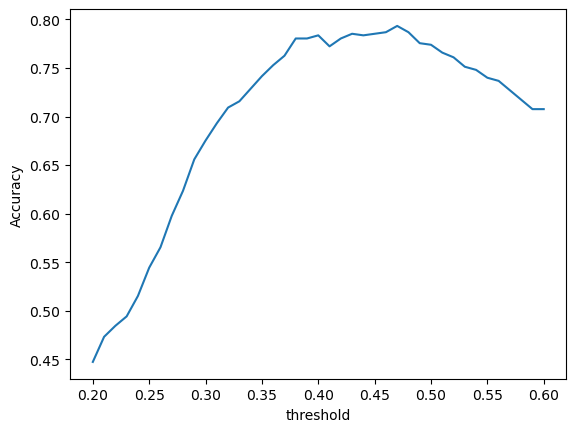

In [143]:
import matplotlib.pyplot as plt
import numpy as np

def fun(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

Acc_list = []
th_list = np.linspace(0.2, 0.6, 41).tolist()
for th in th_list:
    
    pred_list = [fun(i, th) for i in prob_list]
    Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
    Acc_list.append(Acc)
use_th = th_list[Acc_list.index(max(Acc_list))]
print(use_th)
pred_list = [fun(i, use_th) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print(Acc, sensitivity, specificity, PPV, NPV)
plt.plot(th_list, Acc_list)
plt.xlabel('threshold')
plt.ylabel('Accuracy')

In [136]:
post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])

auc_metric = ROCAUCMetric()

prob_list = []
label_list = []

model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in train_loader:

        val_dce, val_adc, val_clinical, val_labels = val_data["image_dce"].to(device),val_data["image_adc"].to(device), val_data["clinical"].to(device), val_data["label"].to(device)
        val_output = model(val_dce, val_adc, val_clinical)
         
        prob_list.append(post_pred(val_output[0])[1].item())  # [0] 是由于设置batch=1 [1] 是是取预测类别中的1类别
        label_list.append(val_labels.item())
        
        # monai
        y_pred = torch.cat([y_pred, val_output], dim=0)
        y = torch.cat([y, val_labels], dim=0)
        
        y_onehot = [post_label(i) for i in decollate_batch(y, detach=False)]
        y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]

# sklearn
pred_list = [round(i) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print('Accuray:', Acc)
print('SEN/SPE:', sensitivity, specificity)
print('PPV/NPV: ', PPV, NPV)

fpr, tpr, thresholds = metrics.roc_curve(label_list, prob_list, pos_label=1)
print(metrics.auc(fpr, tpr))

# # monai
auc_metric(y_pred_act, y_onehot)
print(auc_metric.aggregate())

acc_value = torch.eq(y_pred.argmax(dim=1), y)
acc_metric = acc_value.sum().item() / len(acc_value)
print(acc_metric)

Accuray: 0.7467438494934877
SEN/SPE: 0.33884297520661155 0.9665924276169265
PPV/NPV:  0.845360824742268 0.7306397306397306
0.8583537337333652
0.8583537337333652
0.7467438494934877


In [140]:
import matplotlib.pyplot as plt
import numpy as np

def fun(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

pred_list = [fun(i, 0.45) for i in prob_list]
Acc, sensitivity, specificity, PPV, NPV = report_metric(label_list, pred_list)
print(Acc, sensitivity, specificity, PPV, NPV)


0.7800289435600579 0.5289256198347108 0.9153674832962138 0.7710843373493976 0.7828571428571428


In [113]:
# center  th0.5 (th0.34)  AUC
#sd      0.73(0.844)     0.8663819402074435
#yizhong 0.88(0.84)      0.84 
# xian   0.71(0.76)      0.85
# train 0.75 (0.786)     0.85
(0.84+0.84+0.76+0.786) / 4

0.8065

In [131]:
# center  th0.5   AUC
#sd       0.776  0.86
#yizhong  0.86   0.87
# xian    0.75   0.82
# train   0.778  0.85   
(0.776+0.86+0.75+0.778) / 4

0.791

In [151]:
error_val = []

for val_data in val_loader:

        val_dce, val_adc, val_clinical, val_labels = val_data["image_dce"].to(device),val_data["image_adc"].to(device), val_data["clinical"].to(device), val_data["label"].to(device)
        val_output = model(val_dce, val_adc, val_clinical)
         
        pred_prob = round(post_pred(val_output[0])[1].item())
        label = val_labels.item()
        if pred_prob != label:
            error_val.append(val_data['image_dce_meta_dict']['filename_or_obj'][0])
        
     

In [152]:
len(error_val)

140

In [168]:
image_arr.shape

(44, 109, 89)